## initial configuration

In [2]:
import sys
from pathlib import Path
from importlib import reload

In [3]:
project_path = str(Path.home()/'gd'/'projects')

sys.path.insert(0, project_path + '/ftnmr/scripts')
sys.path.insert(0, project_path + '/projnmr/scripts')
sys.path.insert(0, project_path + '/handson/scripts/part2')
sys.path.insert(0, project_path + '/mods/scripts')

In [4]:
import ftnmr
import projnmr
import handson
import mods
from projnmr import metaboliteGenerator as mg
from string import ascii_letters as al

In [5]:
import os
# for error "not creating xla devices tf_xla_enable_xla_devices not set"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#TF_XLA_FLAGS is an environment variable used by TensorFlow's XLA (Accelerated Linear Algebra) 
#compiler to control its behavior. In this case, setting TF_XLA_FLAGS to 
#--tf_xla_enable_xla_devices enables the XLA compiler to use all available XLA devices, 
#such as GPUs or TPUs, for faster execution of TensorFlow computations.

# for error "Successfully opened dynamic library libcudart.so.10.1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import inspect
import random
import psutil
import gc

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

import tensorflow as tf
from tensorflow import keras

In [7]:
# similar to os.environ['TF_XLA_FLAGS'], but preferred way to enable XLA
tf.config.optimizer.set_jit(True) 

tf.__version__ # TF version

'2.11.1'

In [8]:
devices = tf.config.get_visible_devices()
for dev in devices:
    print(dev.name)

/physical_device:CPU:0
/physical_device:XLA_CPU:0
/physical_device:GPU:0
/physical_device:XLA_GPU:0


In [9]:
tf.test.is_built_with_cuda()

True

In [10]:
import pynvml
pynvml.nvmlInit()

gpus = pynvml.nvmlDeviceGetCount()
for i in range(gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU {i}: Total memory: {info.total / (1024**2)} MB")
    print(f"       Free memory: {info.free / (1024**2)} MB")

pynvml.nvmlShutdown()

GPU 0: Total memory: 16376.0 MB
       Free memory: 16105.125 MB


In [35]:
# Get the Jupyter Lab process ID
jupyter_pid = !pgrep jupyter-lab
jupyter_pid = int(jupyter_pid[0])

# get memory usage of jupyter lab
process = psutil.Process(jupyter_pid)
memory_info = process.memory_info()
print(f"Jupyter Lab memory usage: {memory_info.rss/(1024**2)}MB")

Jupyter Lab memory usage: 91.3125MB


## tf.data.Dataset for memory management and randomization

In [9]:
np.linspace(0, 128, 128, endpoint=False, dtype=np.int32)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32)

In [ ]:
X = np.linspace(0, 128, 128, endpoint=False, dtype=np.int32)
display(type(X))

y = np.linspace(0, 1, 128, endpoint=False, dtype=np.float32)
display(type(y))

B = tf.constant(X)
display(type(B))

B = tf.Variable(X)
display(type(B))

C = tf.data.Dataset.from_tensor_slices(B)
display(type(C))

D = tf.data.Dataset.from_tensor_slices(A)
display(type(D))

E = tf.data.Dataset.from_tensor_slices(A).batch(32)
display(type(E))

F = tf.data.Dataset.from_tensor_slices(A).shuffle(buffer_size=128, seed=42).batch(32)
display(type(F))

G = E.shuffle(buffer_size=4, seed=42)
display(type(G))

H = G.prefetch(tf.data.AUTOTUNE)
display(type(H))

In [ ]:
X = np.linspace(0, 1, 32, endpoint=False, dtype=np.float32)
X = np.around(X, decimals=2)
X

In [ ]:
X = np.linspace(0, 32, 32, endpoint=False, dtype=np.int32)
X

In [ ]:
dataset = tf.data.Dataset \
    .from_tensor_slices(X) \
    .shuffle(buffer_size=128, seed=42) \
    .batch(8) \
    .prefetch(tf.data.AUTOTUNE)

In [ ]:
for item in dataset:
    print(item)
    print()

## creating dataset (VRAM is not taken up for this)

In [12]:
# use the glob() method to find all HDF5 files in subdirectories of the current directory
hdf5_files = Path('./').glob('data*/*.hdf5')

# transform PosixPath type into string type
hdf5_files = [str(file) for file in hdf5_files if 'baseline' in str(file)]
random.shuffle(hdf5_files)
hdf5_files

['data.00a34a1b/baseline08.hdf5',
 'data.00a34a1b/baseline11.hdf5',
 'data.00a34a1b/baseline09.hdf5',
 'data.00a34a1b/baseline10.hdf5',
 'data.00a34a1b/baseline04.hdf5',
 'data.00a34a1b/baseline15.hdf5',
 'data.00a34a1b/baseline01.hdf5',
 'data.00a34a1b/baseline00.hdf5',
 'data.00a34a1b/baseline02.hdf5',
 'data.00a34a1b/baseline14.hdf5',
 'data.00a34a1b/baseline12.hdf5',
 'data.00a34a1b/baseline13.hdf5',
 'data.00a34a1b/baseline06.hdf5',
 'data.00a34a1b/baseline03.hdf5',
 'data.00a34a1b/baseline05.hdf5',
 'data.00a34a1b/baseline07.hdf5']

In [13]:
with h5py.File(hdf5_files[0], 'r') as f:
    dataset = f['data'][:]
    target = f['target']

display(dataset.shape)
num_samples = dataset.shape[0]
len_input = dataset.shape[1]
target

(32768, 1024)

<Closed HDF5 dataset>

In [14]:
hdf5_files = hdf5_files[:8]

In [15]:
total_num_samples = len(hdf5_files)*num_samples
total_num_samples

262144

In [16]:
with h5py.File('chemical_shift.hdf5', 'r') as f:
    shift_range = f['shift'][:]

shift_range

array([0.0000000e+00, 1.5625000e-02, 3.1250000e-02, ..., 1.5953125e+01,
       1.5968750e+01, 1.5984375e+01], dtype=float32)

In [17]:
sample_chunk = int(total_num_samples/8)
sample_chunk

32768

In [18]:
X_train = np.zeros((sample_chunk*6, len_input))
y_train = np.zeros((sample_chunk*6, len_input))

X_valid = np.zeros((sample_chunk, len_input))
y_valid = np.zeros((sample_chunk, len_input))

X_test = np.zeros((sample_chunk, len_input))
y_test = np.zeros((sample_chunk, len_input))

In [19]:
hdf5_files_train = hdf5_files[:6]
hdf5_files_valid = hdf5_files[6:7]
hdf5_files_test = hdf5_files[7:]
hdf5_files_test

['data.00a34a1b/baseline00.hdf5']

In [20]:
for index, file_path in enumerate(hdf5_files_train):
    start = num_samples*index
    with h5py.File(file_path, 'r') as f:
        X_train[start:start+num_samples] = f['data'][:]
        y_train[start:start+num_samples] = f['target'][:]

X_train.shape

(196608, 1024)

In [21]:
for index, file_path in enumerate(hdf5_files_valid):
    start = num_samples*index
    with h5py.File(file_path, 'r') as f:
        X_valid[start:start+num_samples] = f['data'][:]
        y_valid[start:start+num_samples] = f['target'][:]

for index, file_path in enumerate(hdf5_files_test):
    start = num_samples*index
    with h5py.File(file_path, 'r') as f:
        X_test[start:start+num_samples] = f['data'][:]
        y_test[start:start+num_samples] = f['target'][:]

X_test.shape

(32768, 1024)

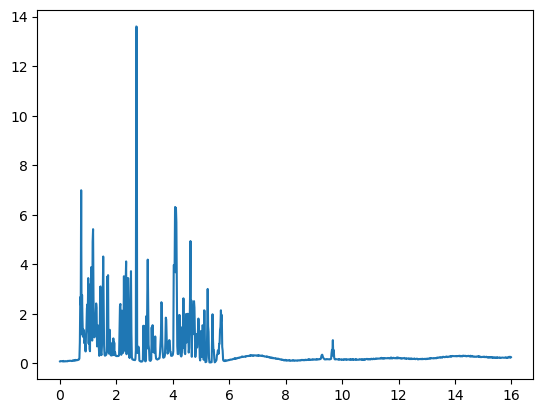

In [22]:
plt.plot(shift_range, X_train[14])
plt.show()

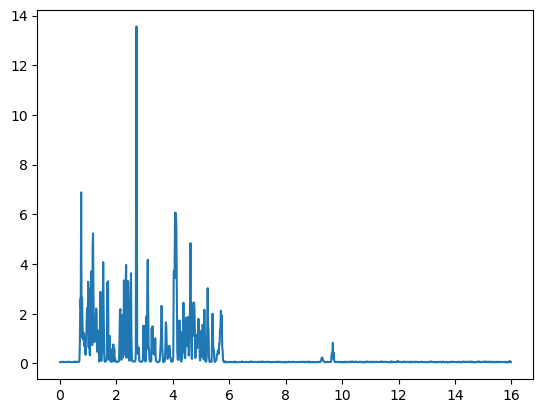

In [24]:
plt.plot(shift_range, y_train[14])
plt.show()

In [25]:
buffer_size = int(X_valid.shape[0]/8)
buffer_size

4096

In [26]:
dataset_train = tf.data.Dataset \
    .from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=buffer_size, seed=42) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

dataset_valid = tf.data.Dataset \
    .from_tensor_slices((X_valid, y_valid)) \
    .shuffle(buffer_size=buffer_size, seed=42) \
    .batch(32) \
    .prefetch(tf.data.AUTOTUNE)

## testing MaxPool1D

In [ ]:
with h5py.File('chemical_shift.hdf5', 'r') as f:
    # Access the dataset
    dataset = f['shift']
    # Load the dataset into memory as a NumPy array
    shift = dataset[:]

shift.shape

with h5py.File('data.2022-03-06~01:42PM/baseline00.hdf5', 'r') as f:
    X = f['data'][:]
    y = f['target'][:]

X.shape

In [ ]:
plt.plot(shift, X[4])
plt.show()

In [ ]:
test_intput = np.expand_dims(X[4], axis=-1)
print(test_intput.shape)

test_intput = np.expand_dims(test_intput, axis=0)
print(test_intput.shape)

input_tensor = tf.convert_to_tensor(test_intput, dtype=tf.float32)
input_tensor

In [ ]:
input_vector = keras.layers.Input([65536, 1])
input_vector

In [ ]:
pool_output = keras.layers.MaxPool1D(16)(input_vector)
pool_output

In [ ]:
test_output = keras.layers.MaxPool1D(32)(input_tensor)
test_output

In [ ]:
reduced_shift = shift[::32]
reduced_shift.shape

In [ ]:
numpy_output = test_output.numpy()
numpy_output.shape

In [ ]:
reshape_output = numpy_output.reshape(2048)
reshape_output.shape

In [ ]:
plt.plot(reduced_shift, reshape_output)
plt.show()

## getting file paths

In [ ]:
# use the glob() method to find all HDF5 files in subdirectories of the current directory
hdf5_files = Path('.').glob('**/*.hdf5')

# transform PosixPath type into string type
hdf5_files = [str(file) for file in hdf5_files if 'baseline' in str(file)]
hdf5_files

In [ ]:
# split the datasets into train, valid, test
files_train = hdf5_files[:-2]
files_valid = hdf5_files[-2:-1]
files_test = hdf5_files[-1:]

files_train

In [ ]:
def data_generator(file_paths, num_samples=512, batch_size=64):
    np.random.shuffle(file_paths)
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            idx = np.random.permutation(num_samples)
            data = f['data'][:][idx]
            target = f['target'][:][idx]
            
            for i in range(0, num_samples, batch_size):
                data = f['data'][i:i+batch_size]
                target = f['target'][i:i+batch_size]
                yield f['data'][i:i+batch_size], f['target'][i:i+batch_size]

## transposed convolution layer

In [ ]:
input_shape = (2, 2)
kernel_size = (2, 2)
stride = 1
num_filters = 1

sqm = lambda n: np.expand_dims(np.arange(n**2).reshape(n, n), axis=-1)
lins = lambda n: np.array([np.expand_dims(np.linspace(0, n-1, n), axis=-1)])

In [ ]:
input_tensor = tf.constant([lins(4)], dtype=tf.float32)
matd(input_tensor[0][:, :, 0].numpy())

In [ ]:
input_tensor = tf.constant([sqm(3)], dtype=tf.float32)
matd(input_tensor[0][:, :, 0].numpy())

In [ ]:
kernel_weights = sqm(4)[:1, :, 0]
matd(kernel_weights)
print('kernel_weights')

In [ ]:
?keras.layers.Conv2DTranspose

In [ ]:
output_shape = (None, 3, 3, 1)

# Define the transposed Conv2D layer
tc2_layer = tf.keras.layers.Conv2DTranspose(
    filters=num_filters,
    kernel_size=kernel_weights.shape,
    strides=(1, 2),
    padding='valid',
    kernel_initializer=tf.constant_initializer(kernel_weights),
    #output_padding=
)

# Apply tc2_layer to the input tensor
output_tensor = tc2_layer(input_tensor)
matd(output_tensor[0][:, :, 0].numpy())

## Dynamic Data Generation

In [14]:
spec = ftnmr.spectrometer(shift_maximum=128.0)

mods.print_formatted(spec.nf, spec.nf*spec.df, spec.t[-1], 213)
print()
mods.print_formatted(spec.df, spec.ns, spec.dt, spec.f_s, spec.p, spec.p_l)

 66k      7       2k    213 

104μ    131k     18m     54      19       3 


In [26]:
ru = np.random.uniform
rr = np.random.randint
moles = {al[26+k]:(mg(), ru(0, 50)) for k in range(0, rr(1, 15))}
moles

{'A': (<ftnmr.molecule at 0x2adc3fb6d6f0>, 24.62431070335722),
 'B': (<ftnmr.molecule at 0x2adc3fb6df90>, 3.2855205528781406),
 'C': (<ftnmr.molecule at 0x2adc3fb6ec80>, 38.968035854981956),
 'D': (<ftnmr.molecule at 0x2adc3fb6e020>, 32.57838808596052),
 'E': (<ftnmr.molecule at 0x2adc3fb6c3d0>, 34.42890755861344),
 'F': (<ftnmr.molecule at 0x2adc3fb6e5f0>, 5.0261667842767865),
 'G': (<ftnmr.molecule at 0x2adc3fb6dae0>, 33.67101776629462),
 'H': (<ftnmr.molecule at 0x2adc3fb6d630>, 9.812428546082918),
 'I': (<ftnmr.molecule at 0x2adc3fb6d450>, 0.20865555059009777),
 'J': (<ftnmr.molecule at 0x2adc3fb6fe50>, 0.3667209082063694),
 'K': (<ftnmr.molecule at 0x2adc3fb6e590>, 8.77836358743232),
 'L': (<ftnmr.molecule at 0x2adc3fb6dcc0>, 3.0201966047178286),
 'M': (<ftnmr.molecule at 0x2adc3fb6dcf0>, 32.95320987816269)}

In [31]:
spec.artifact(baseline=True)
spec.measure(moles=moles)

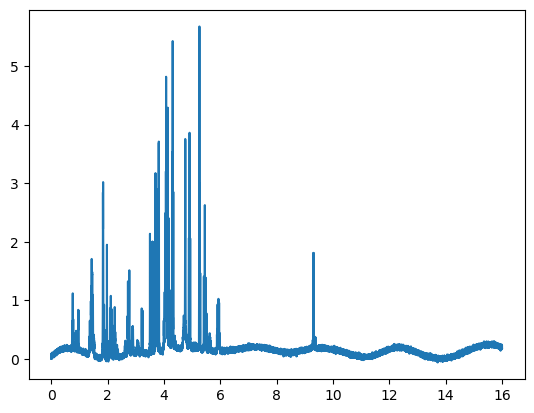

In [32]:
plt.plot(spec.shift, spec.spectra)

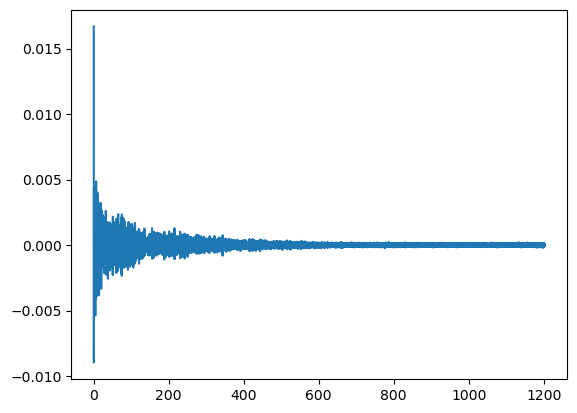

In [33]:
plt.plot(spec.t[:spec.nf], spec.signal.real[:spec.nf])

In [36]:
input_size = 2**10
print(f"input size: {input_size}")
rescale_ratio = int(spec.nf/input_size)
target = np.reshape(spec.target, (input_size, rescale_ratio))
spectra = np.reshape(spec.spectra, (input_size, rescale_ratio))

max_target = np.max(target, axis=1)
mean_target = np.mean(target, axis=1)
max_spectra = np.max(spectra, axis=1)
mean_spectra = np.mean(spectra, axis=1)

rescaled_shift = spec.shift[::rescale_ratio]

input size: 1024


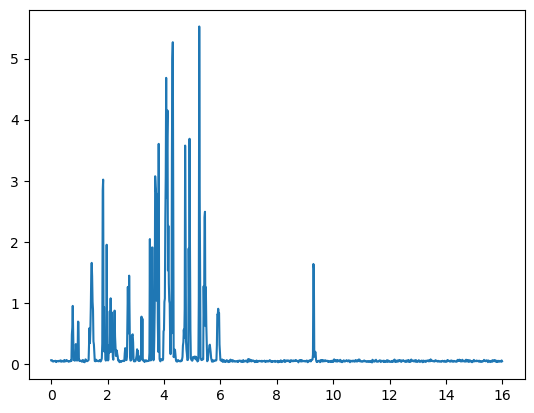

In [37]:
plt.plot(rescaled_shift, max_target)

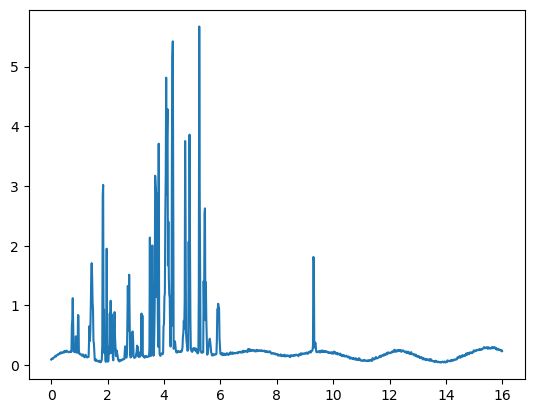

In [38]:
plt.plot(rescaled_shift, max_spectra)

In [ ]:
# random generation and measurements of metabolites
for m in range(0, number_of_measurements):
    num_of_moles = np.random.randint(1, 15)
    moles = {al[26+k]:(mg(), np.random.uniform(0, 50)) for k in range(0, num_of_moles)}
    spec.artifact(baseline=True)
    spec.measure(moles=moles)
    data[m, :], target[m, :] = spec()

In [51]:
2**16

65536

In [52]:
2**10

1024

In [53]:
65536/1024

64.0

## Testing Model

In [27]:
# configuration
input_length = len_input
expand_layer = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
GRU_unit = 16
first_filter_num = 128
transpose_layer = keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 1, 3, 2]))
second_filter_num = 64

In [ ]:
seq_input = keras.layers.Input(shape=[input_length])
seq_input

In [ ]:
expand_output = expand_layer(seq_input)
expand_output

In [ ]:
#skip
pool_output = keras.layers.MaxPool1D(pool_size)(expand_output)
pool_output

In [ ]:
GRU_output = keras.layers.Bidirectional(
    keras.layers.GRU(GRU_unit, return_sequences=True))(expand_output)
GRU_output

In [ ]:
expand_output2 = expand_layer(GRU_output)
expand_output2

In [ ]:
cnn_layer1 = keras.layers.Conv2D(
    filters=first_filter_num, 
    kernel_size=(1, 2*GRU_unit), 
    activation='elu')
cnn_output1 = cnn_layer1(expand_output2)
cnn_output1

In [ ]:
transpose_output = transpose_layer(cnn_output1)
transpose_output

In [ ]:
cnn_layer2 = keras.layers.Conv2D(
    filters=second_filter_num, 
    kernel_size=(1, first_filter_num),
    activation='selu')
cnn2_output = cnn_layer2(transpose_output)
cnn2_output

In [ ]:
transpose2_output = transpose_layer(cnn2_output)
transpose2_output

In [ ]:
cnn_layer3 = keras.layers.Conv2D(
    filters=1, 
    kernel_size=(1, second_filter_num),
    activation='selu')
cnn3_output = cnn_layer3(transpose2_output)
cnn3_output

In [ ]:
#skip
upscale_output = keras.layers.UpSampling2D(
    size=(pool_size, 1), 
    interpolation='bicubic')(cnn3_output)
upscale_output

In [ ]:
flat_output = keras.layers.Flatten()(cnn3_output)
flat_output

In [ ]:
model_output = keras.layers.Add()([seq_input, flat_output])
model_output

In [51]:
expand_output

<KerasTensor: shape=(None, 512, 1) dtype=float32 (created by layer 'lambda_2')>

In [29]:
# same as above execution of cells, but all the cells are merged
seq_input = keras.layers.Input(shape=[input_length])

expand_output = expand_layer(seq_input)

GRU_output = keras.layers.Bidirectional(
    keras.layers.GRU(GRU_unit, return_sequences=True))(expand_output)

expand_output2 = expand_layer(GRU_output)

cnn_layer1 = keras.layers.Conv2D(
    filters=first_filter_num, 
    kernel_size=(1, 2*GRU_unit), 
    activation='elu')
cnn_output1 = cnn_layer1(expand_output2)

transpose_output = transpose_layer(cnn_output1)

cnn_layer2 = keras.layers.Conv2D(
    filters=second_filter_num, 
    kernel_size=(1, first_filter_num),
    activation='selu')
cnn2_output = cnn_layer2(transpose_output)

transpose2_output = transpose_layer(cnn2_output)

cnn_layer3 = keras.layers.Conv2D(
    filters=1, 
    kernel_size=(1, second_filter_num),
    activation='selu')
cnn3_output = cnn_layer3(transpose2_output)

flat_output = keras.layers.Flatten()(cnn3_output)

model_output = keras.layers.Add()([seq_input, flat_output])

In [30]:
model = keras.Model(inputs=[seq_input], outputs=[model_output])

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [35]:
model.compile(
    loss="mse", 
    optimizer=keras.optimizers.Nadam(),
    metrics=['mse'])

In [36]:
history = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_valid,
    callbacks=[early_stopping_cb])

Epoch 1/20
6144/6144 [==============================] - 221s 35ms/step - loss: 1.0276e-04 - mse: 1.0276e-04 - val_loss: 5.7127e-05 - val_mse: 5.7127e-05
Epoch 2/20
6144/6144 [==============================] - 219s 36ms/step - loss: 8.2391e-05 - mse: 8.2391e-05 - val_loss: 5.2005e-05 - val_mse: 5.2005e-05
Epoch 3/20
6144/6144 [==============================] - 219s 36ms/step - loss: 6.3250e-05 - mse: 6.3250e-05 - val_loss: 4.9052e-05 - val_mse: 4.9052e-05
Epoch 4/20
6144/6144 [==============================] - 219s 36ms/step - loss: 4.4298e-05 - mse: 4.4298e-05 - val_loss: 4.4926e-05 - val_mse: 4.4926e-05
Epoch 5/20
6144/6144 [==============================] - 219s 36ms/step - loss: 4.7194e-05 - mse: 4.7194e-05 - val_loss: 3.6404e-05 - val_mse: 3.6404e-05
Epoch 6/20
6144/6144 [==============================] - 219s 36ms/step - loss: 4.7180e-05 - mse: 4.7180e-05 - val_loss: 4.5936e-05 - val_mse: 4.5936e-05
Epoch 7/20
6144/6144 [==============================] - 219s 36ms/step - loss: 2.0

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 lambda (Lambda)                multiple             0           ['input_1[0][0]',                
                                                                  'bidirectional[0][0]']          
                                                                                                  
 bidirectional (Bidirectional)  (None, 1024, 32)     1824        ['lambda[0][0]']                 
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1, 128  4224        ['lambda[1][0]']             

In [39]:
model.save('prototype01.hdf5')

In [28]:
loaded_model = keras.models.load_model('prototype01.hdf5', compile=False)

In [30]:
y_pred = loaded_model.predict(X_test)

1024/1024 [==============================] - 18s 14ms/step


25948


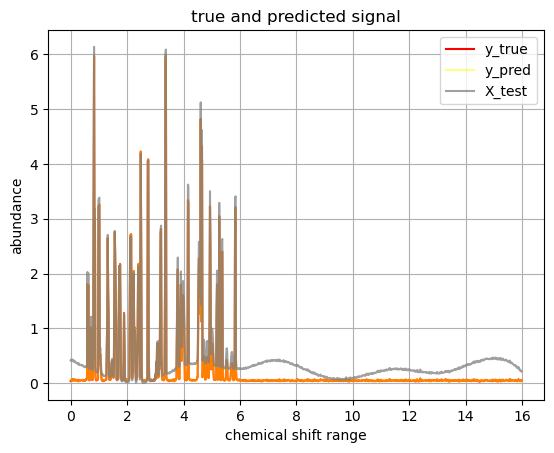

In [43]:
ind = np.random.choice(range(len(y_pred)))
x_t = X_test[ind]
y_true = y_test[ind]
y_p = y_pred[ind]
print(ind)

# Plot the first graph
plt.plot(shift_range, y_true, label='y_true', color='red')

# Plot the second graph
plt.plot(shift_range, y_p, label='y_pred', color='yellow', alpha=0.50)

# Plot the third graph
plt.plot(shift_range, x_t, label='X_test', color='grey', alpha=0.75)

# Set the labels and title
plt.xlabel('chemical shift range')
plt.ylabel('abundance')
plt.title('true and predicted signal')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

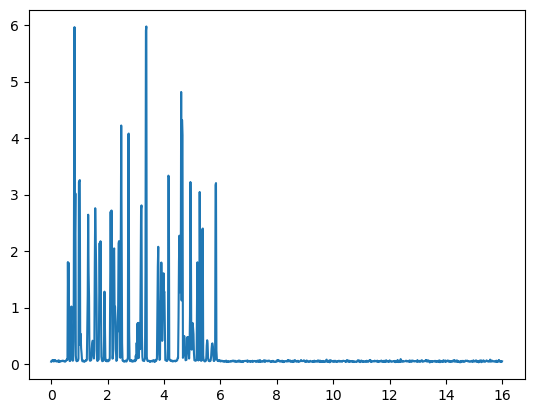

In [44]:
# Plot the first graph
plt.plot(shift_range, y_true, label='y_true')
plt.show()

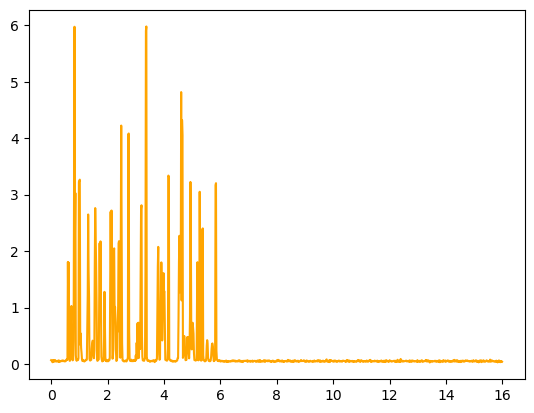

In [45]:
# Plot the second graph
plt.plot(shift_range, y_p, label='y_pred', color='orange')
plt.show()

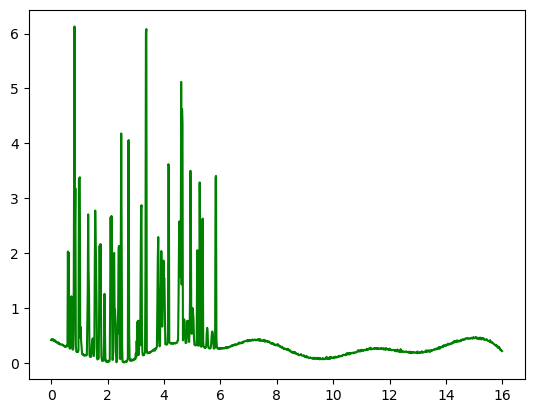

In [46]:
# Plot the third graph
plt.plot(shift_range, x_t, label='X_test', color='green')
plt.show()